# Background

This mini-project explores the *Yelp review* dataset obtained from [Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).
It contains 10000 reviews from the Yelp users.

The purpose of this project is to develop and deploy various Natural Language Processing (NLP) pipelines to classify the `reviews` into `stars` between 1 and 5. 

* Each observation in this dataset is a review of a particular business by a particular user.
* The `stars` is the number of stars (1 through 5) assigned by the reviewer to the business. Higher stars is better.
* The `cool` is the number of cool votes this review received from other Yelp users. 
* The `useful` and `funny` are similar to the `cool` column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

# Data overview

In [2]:
df_yelp = pd.read_csv('Data/yelp.csv')

** Check the head, info , and describe methods on yelp.**

In [3]:
df_yelp.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
df_yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


#### New feature extraction for EDA: `text length`

In [5]:
df_yelp['text length'] = df_yelp['text'].apply(len)

# EDA
#### Target variable distribution

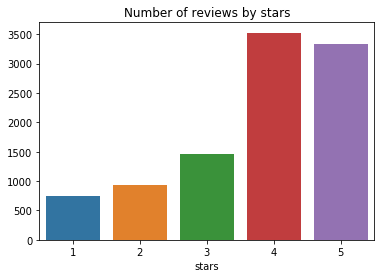

In [6]:
sns.countplot('stars',data=df_yelp)
plt.title('Number of reviews by stars')
plt.ylabel('')
plt.show()

The target variable is negatively skewed towards higher stars.

#### Text length distribution in each `stars` class

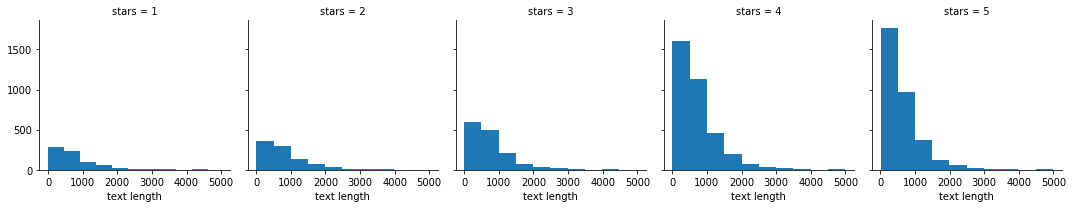

In [7]:
g = sns.FacetGrid(col='stars',data=df_yelp)
g.map(plt.hist,'text length')
plt.show()

It seems like the distributions of `text length` in each `stars` class are quite similar. It may not possesses a strong predictive power.

#### Boxplot of text length for each star category

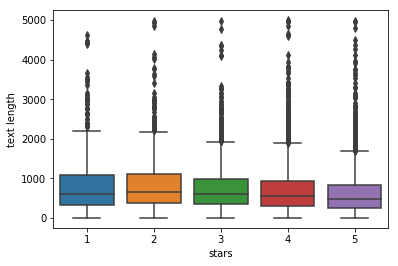

In [8]:
sns.boxplot('stars','text length',data=df_yelp)
plt.show()

As expected from the above figure, the `text length` shows similar distribution in each `stars` category. All of them are positively skewed with simliar mean values near 800. 

#### Correlation of each features

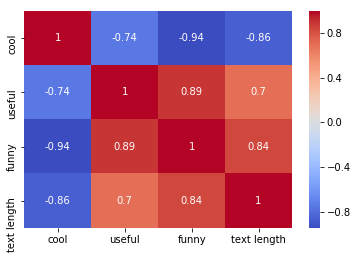

In [9]:
sns.heatmap(df_yelp.groupby('stars').mean().corr(),annot=True,cmap='coolwarm')
plt.show()

`text length` is highly correlated with both `funny` and `useful`. `funny` and `useful` are strongly correlated as well. However, `cool` seems to convey *negative* attitudes of the yelp users.

# Pre-processing
#### For the scope of this project, only the `text` feature will be used to classify `stars`.


In [10]:
df_yelp = df_yelp[['text','stars']]

#### Train and test split

In [11]:
X = df_yelp['text']
y = df_yelp['stars']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

# NLP pipeline #1 with grid search
#### Bag of words and TF-IDF transformation with Multinomial Naive Bayes classifier

In [12]:
pipeline_1 = Pipeline([
    ('bow', CountVectorizer()),
    ('tt',TfidfTransformer()),
    ('classifier', MultinomialNB())
    ])

In [13]:
grid_param_1 = {'classifier__alpha':[0.1,0.3,1,3,10]}
grid_pipeline_1 = GridSearchCV(pipeline_1,grid_param_1,cv=3,verbose=1).fit(X_train,y_train)



Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.3s finished


In [14]:
print('best parameter: {}'.format(grid_pipeline_1.best_params_))
print('best score: {:.3f}'.format(grid_pipeline_1.best_score_))

best parameter: {'classifier__alpha': 0.1}
best score: 0.442


In [15]:
pred_1 = grid_pipeline_1.predict(X_test)

In [16]:
print(classification_report(y_test,pred_1))

              precision    recall  f1-score   support

           1       0.76      0.11      0.20       192
           2       0.50      0.02      0.04       243
           3       0.30      0.02      0.03       366
           4       0.40      0.73      0.51       886
           5       0.53      0.53      0.53       813

   micro avg       0.44      0.44      0.44      2500
   macro avg       0.50      0.28      0.26      2500
weighted avg       0.46      0.44      0.38      2500



#### Pipeline #1 evaluation

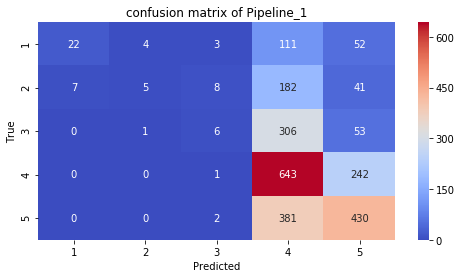

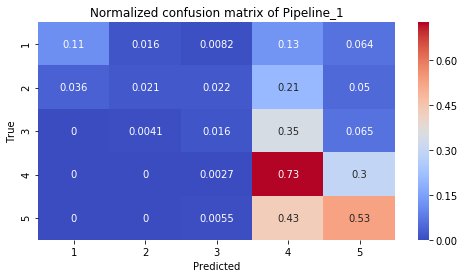

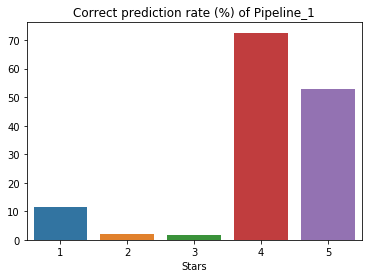

In [17]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test,pred_1),columns=list('12345'),index=list('12345'))
confusion_mtx_normalized = confusion_mtx/confusion_mtx.sum(axis=1)

plt.figure(figsize=(8,4))
sns.heatmap(confusion_mtx,annot=True,cmap='coolwarm',fmt='d')
plt.title('confusion matrix of Pipeline_1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(8,4))
sns.heatmap(confusion_mtx_normalized,annot=True,cmap='coolwarm')
plt.title('Normalized confusion matrix of Pipeline_1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure()
plt.title('Correct prediction rate (%) of Pipeline_1')
sns.barplot(np.arange(1,6),np.diag(confusion_mtx_normalized)*100)
plt.xlabel('Stars')
plt.show()

# NLP pipeline #2 with grid search
#### Bag of words with Multinomial Naive Bayes classifier

In [18]:
pipeline_2 = Pipeline([
    ('bow', CountVectorizer()),
    ('classifier', MultinomialNB())
    ])

In [19]:
grid_param_2 = {'classifier__alpha':[0.1,0.3,1,3,10]}
grid_pipeline_2 = GridSearchCV(pipeline_2,grid_param_2,cv=3,verbose=1).fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   19.6s finished


In [20]:
print('best parameter: {}'.format(grid_pipeline_2.best_params_))
print('best score: {:.3f}'.format(grid_pipeline_2.best_score_))

best parameter: {'classifier__alpha': 0.3}
best score: 0.494


In [21]:
pred_2 = grid_pipeline_2.predict(X_test)

In [22]:
print(classification_report(y_test,pred_2))

              precision    recall  f1-score   support

           1       0.49      0.45      0.47       192
           2       0.38      0.22      0.28       243
           3       0.37      0.28      0.32       366
           4       0.48      0.60      0.53       886
           5       0.58      0.57      0.57       813

   micro avg       0.49      0.49      0.49      2500
   macro avg       0.46      0.42      0.43      2500
weighted avg       0.49      0.49      0.48      2500



#### Pipeline #2 evaluation

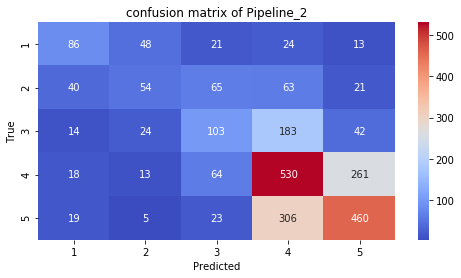

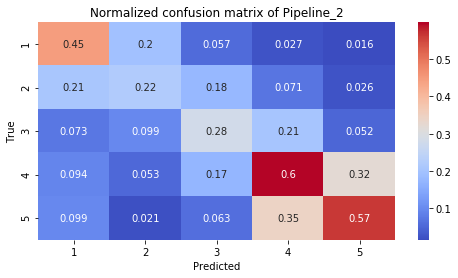

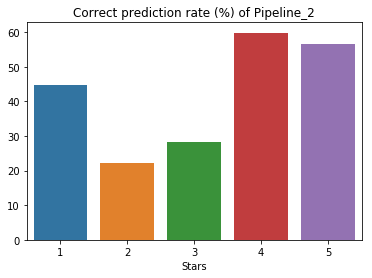

In [23]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test,pred_2),columns=list('12345'),index=list('12345'))
confusion_mtx_normalized = confusion_mtx/confusion_mtx.sum(axis=1)

plt.figure(figsize=(8,4))
sns.heatmap(confusion_mtx,annot=True,cmap='coolwarm',fmt='d')
plt.title('confusion matrix of Pipeline_2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(8,4))
sns.heatmap(confusion_mtx_normalized,annot=True,cmap='coolwarm')
plt.title('Normalized confusion matrix of Pipeline_2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure()
plt.title('Correct prediction rate (%) of Pipeline_2')
sns.barplot(np.arange(1,6),np.diag(confusion_mtx_normalized)*100)
plt.xlabel('Stars')
plt.show()

# Conclusion
As the target variable class was heavily imbalanced, roughly processed NLP classifiers tried in this project did not show impressive performance in `stars` prediction. While the average performance of the two pipelines tried appear to be similar, the pipeline #2 without TF-IDF processing was better at generalization.

For further optimization, along with the NLP features, other features such as `cool` and `funny` can be taken into account. In addition, the class imblance issue can be addressed by implementing weight balancing or possibly downsampling star 4 and star 5 classes.